Importing tensorflow and other modules

In [12]:
import tensorflow as tf
import npnelib as ne
import numpy as np
import scipy

Defining dcd coordinate reading function, tf (for finding the time series between two atoms) and find maximum Zc,1 derivation function.

In [13]:
def read_dcd(name,verb=False,natom=0,nsets=0):
    import numpy as np
    from scipy.io import FortranFile
    f=FortranFile(name,'r')
    hdr=f.read_record(np.dtype('i4'))
    if verb:print (hdr)
    nsetsdcd=hdr[1]
    if nsets==0:nsets=nsetsdcd
    extrablock=hdr[11]>0
    if verb:print (nsets,extrablock)
    ntitle=f.read_record(np.dtype('i4'))
    if verb:print (ntitle)
    natomdcd=f.read_record(np.dtype('i4'))[0]
    if natom==0:natom=natomdcd
    mask=np.full(natomdcd,True)
    if natomdcd!=natom: # reading a (random) subset of atoms
        mask=np.full(natomdcd,False)
        mask[:natom]=True
        np.random.shuffle(mask)
    if verb:print (natom)
    xyz=np.zeros((natom,3,nsets),dtype=np.float16)
    for iset in range(nsets):
        if iset % max(1,int(nsets/10))==0:print (iset)
        if extrablock: cell=f.read_record(np.dtype('f4'))
        xyz[:,0,iset]=f.read_record(np.dtype('f4'))[mask]
        xyz[:,1,iset]=f.read_record(np.dtype('f4'))[mask]
        xyz[:,2,iset]=f.read_record(np.dtype('f4'))[mask]
    f.close()
    return natom,nsets,xyz

@tf.function
def rij(r1,r2):
    dr=r1-r2
    dr2=tf.math.reduce_sum(dr*dr,axis=0)
    dr=tf.math.sqrt(dr2)
    return dr/tf.math.reduce_max(dr)

def find_maxzc1(r):
    lx,lzc1=ne.comp_Zca(r,1,dx=0.01,dt=1)
    mzc1=sum(lzc1)/len(lzc1)
    return max([((zc1/mzc1-1),x) for x,zc1 in zip(lx,lzc1)])

Opening the rmsd file to define boundry states and opening dcd to give coordinates. 

In [14]:
f=open('redtraj-3-0.rmsd')
lrmsd=[]
for l in f:
    l=l.split()
    lrmsd.append(float(l[1]))
f.close()
rmsd=np.asarray(lrmsd)

natom,nsets,xyz=read_dcd('redcomb.dcd')
xyz = tf.convert_to_tensor(xyz, np.float16)

print (xyz.shape)

0
125917
251834
377751
503668
629585
755502
881419
1007336
1133253
1259170
(627, 3, 1259172)


xyz reads the 3D coordinates and defines the order perameters.

We define the boundry states of the RC where r(A)=0 and r(B)=1. It(t) is the indicator function: it equals 1 when 
itraj(t)=itraj(t+dt). Ib is the boundry indicator function, it is 1 when X(t) is on a boundry and 0 not on a boundry. 
It is fixed during optimisation, and is zero otherwise. 
We Define 4 and 11 to be the boundry states as determined from the FEP as a function of rmsd plot of redtraj-5-0. 

In [15]:
r=np.ones_like(rmsd,np.float64)/2
r[rmsd<4.0]=0
r[rmsd>11.0]=1

Ib=np.zeros_like(rmsd,np.float64)
Ib[rmsd<4.0]=1 
Ib[rmsd>11.0]=1 

It=np.ones_like(rmsd,np.float64)

every 1000 iterations, print:
iteration number, ||r-r_{-1000}||, dr**2/2, max dZ{C,1}, r0 

40000 iterations will be produced. 

In [16]:
ro=r
df=0
r0=0
lr1=[]
lr2=[]
k=0
np.random.seed(100)
while k<1000000:
    i,j=np.random.choice(range(natom),2,replace=False)
    y=rij(xyz[i,:,:],xyz[j,:,:])
    y=tf.cast(y,tf.float64)
    
    r=ne.NPNEq(r,ne.basis_poly_ry(r,y,4),Ib,It)
  
    if k%1000==0:
        dr=r-ro
        dr2=tf.tensordot(dr,dr,1).numpy()
        dr2=dr2**0.5
        lr1.append((k,dr2))
        dr=r-tf.roll(r,-1,0)
        dr2=tf.tensordot(dr*It,dr,1).numpy()/2
        lr2.append((k,dr2))
        print (k,lr1[-1][1],lr2[-1][1],df,r0)
        if k>=10000:break
        ro=r
    k+=1

0 370.30121171152393 12.993837498494639 0 0
1000 13.565123888580844 1.0034076118937365 0 0
2000 5.380555219049591 0.9999999999937232 0 0
3000 1.6414119072135143e-07 0.9999999999877824 0 0
4000 1.245437476261097e-07 0.9999999999625432 0 0
5000 1.136047613263078e-07 0.9999999999878406 0 0
6000 1.1663633608305191e-07 0.999999999981419 0 0
7000 1.0470876042581233e-07 0.999999999991811 0 0
8000 8.445350134813846e-08 0.9999999999955295 0 0
9000 8.455619920882165e-08 1.0000000000004197 0 0
10000 7.419542162427149e-08 0.9999999999983615 0 0


Shift in ||r-r-n|| is tiny at 10000 iterations. r0 ramians constant at 1, dr**2/2 is constant at 11, max dZ{C,1} stays at 0 meaning it remains constant past 10000 iterations as well. 

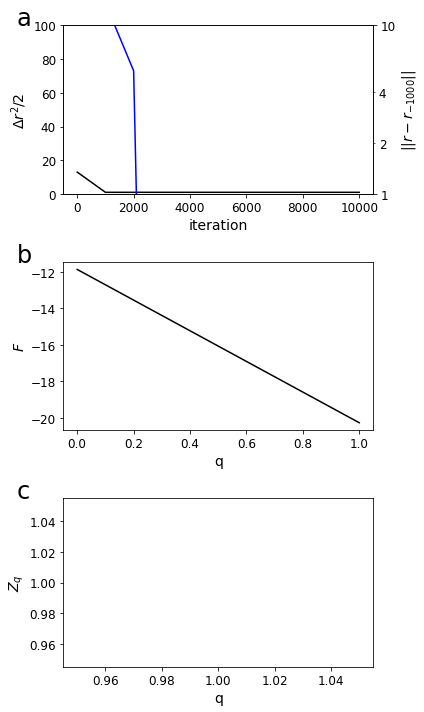

In [21]:
qp=r.numpy()
ar1=np.asarray(lr1)
ar2=np.asarray(lr2)


%matplotlib inline
import matplotlib.pyplot as plt

plt.rc('font', size=10)          # controls default text sizes
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize
plt.rc('figure', titlesize=14)  # fontsize of the figure title

fig,(ax1,ax2,ax3)=plt.subplots(3,1,figsize=(6,10))
        
ax1b=ax1.twinx()
ax1b.plot(ar1[1:,0],ar1[1:,1],'b')
ax1b.set(ylabel='$||r-r_{-1000}||$')

from matplotlib.ticker import FormatStrFormatter
ax1b.set(yscale='log',ylim=(1,10))
ax1b.yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax1b.yaxis.set_minor_formatter(FormatStrFormatter('%g'))
ax1b.yaxis.set_ticks([1,2,4,10],minor=True)
ax1.set(xlabel='iteration',ylabel='$\Delta r^2/2$')
ax1.plot(ar2[:,0],ar2[:,1],'k')
_=ax1.set(ylim=(0,100))


import npnelib as ne 
from math import log

dx=0.002
lx,lzh=ne.comp_Zh(qp,dx=dx)
lf=[-log(z) for z in lzh if z>0]

lx2,lzh2=ne.comp_Zca(qp,a=-1,dx=dx,eq=True)
lf2=[-log(z*2) for z in lzh2 if z>0]

ax2.plot(lx,lf,'k-',label='$F_H$')
ax2.set(xlabel='q',ylabel='$F$')

dx=0.0005
ldt=[2**i for i in range(16)]
for dt in ldt:
    ekn=ne.comp_ekn_tp(qp,x0=0,x1=1,dx=dx,dt=dt)
    lx,lzc1=ne.comp_Zca_ekn(ekn,a=1)
    ax3.plot(lx,lzc1)

ax3.set(xlabel='q',ylabel='$Z_q$')
ax1.text(-.15,1,'a',fontsize=24,transform=ax1.transAxes)
ax2.text(-.15,1,'b',fontsize=24,transform=ax2.transAxes)
ax2.text(-.15,1,'c',fontsize=24,transform=ax3.transAxes)

plt.tight_layout()
_=plt.savefig('fig11.pdf',dpi=600)

Fq and Zqq plots indicate a poor model fit - this rmsd is a poor representitive RC